# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [67]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')
LR_model = joblib.load('LR_trained_model.joblib')

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [68]:
X = pd.DataFrame({
    'su_pcp_w': pcp_data['sup_lake'],
    'er_pcp_w': pcp_data['eri_lake'],
    'on_pcp_w': pcp_data['ont_lake'],
    'mh_pcp_w': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_pcp_l': pcp_data['sup_land'],
    'er_pcp_l': pcp_data['eri_land'],
    'on_pcp_l': pcp_data['ont_land'],
    'mh_pcp_l': pcp_data['mic_land']+pcp_data['hur_land'],
    'su_evap_w': evap_data['sup_lake'],
    'er_evap_w': evap_data['eri_lake'],
    'on_evap_w': evap_data['ont_lake'],
    'mh_evap_w': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_evap_l': evap_data['sup_land'],
    'er_evap_l': evap_data['eri_land'],
    'on_evap_l': evap_data['ont_land'],
    'mh_evap_l': evap_data['mic_land']+evap_data['hur_land'],
    'su_tmp_w': tmp_data['sup_lake'],
    'er_tmp_w': tmp_data['eri_lake'],
    'on_tmp_w': tmp_data['ont_lake'],
    'mh_tmp_w': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2,
    'su_tmp_l': tmp_data['sup_land'],
    'er_tmp_l': tmp_data['eri_land'],
    'on_tmp_l': tmp_data['ont_land'],
    'mh_tmp_l': (tmp_data['mic_land']+tmp_data['hur_land'])/2
})
print(X)

         su_pcp_w    er_pcp_w    on_pcp_w     mh_pcp_w     su_pcp_l  \
0      636.369837  300.622778   63.822853  2466.485814  1652.077148   
1     2744.115733  375.388680  181.523281  2534.983177  6302.072992   
2     2605.488977  540.368897  271.529871  5117.100000  5124.974193   
3     2062.170153  677.219713  298.480950  2658.118961  4207.967037   
4     1852.993242  532.976397  292.464141  2550.001095  2882.919665   
...           ...         ...         ...          ...          ...   
2132  1690.325117  551.967312  293.463991  2542.295275  2789.370265   
2133  1463.935349  405.171747  200.465676  2146.633976  2814.223965   
2134  2389.472732  540.328969  268.308446  3964.111777  5073.034293   
2135   711.069834  439.149630   91.029991  2845.172214  2080.422379   
2136  1303.302512  397.833674  280.491368  3657.209591  3776.439484   

         er_pcp_l     on_pcp_l      mh_pcp_l    su_evap_w   er_evap_w  ...  \
0     2323.615451  1118.073131   7139.162678   902.196763  591.158547

Standardize the data

In [69]:
# Standardize the data
#scaler = StandardScaler()
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [70]:
# Predict using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred_gp = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_gp = pd.DataFrame(y_pred_gp, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_gp)

          su_evap    su_precip    su_runoff      er_evap   er_precip  \
0     1606.610352  1864.804066  1083.173354  1392.019081  892.702599   
1     2530.576262  3255.507588  1010.219212  1911.494320  850.886790   
2     3321.539056  2349.940053   775.118732  1840.266042  982.174860   
3     3448.345804  1717.723307   995.758400  1463.821046  992.490001   
4     4502.707929  1423.861294   560.196876  1114.369518  660.785555   
...           ...          ...          ...          ...         ...   
2132  3278.053424  1250.418398   361.274869   554.538724  726.398065   
2133  2756.297460  1106.249852   509.049458   531.121988  501.514066   
2134  1606.419608  1935.047713  1479.057388   611.166584  992.017383   
2135   870.511659  1158.300232  1399.557726   791.292002  899.133969   
2136   639.685497  1997.156940   979.802169  1081.481130  913.684307   

        er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
0      405.563804  626.171053  494.249587   855.869115  1423.833

In [73]:
# Predict using LR NO SCALING
y_pred_lr = LR_model.predict(X)

df_y_lr = pd.DataFrame(y_pred_lr, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_lr)

          su_evap    su_precip    su_runoff      er_evap   er_precip  \
0     1193.956389  1621.158277  1463.498072  1803.211331  930.879751   
1     3242.433050  3570.995449  1814.923087  2049.321239  787.977303   
2     3620.630664  2963.891381  1741.943076  1745.251644  909.575099   
3     3423.061235  1980.906331  1682.857940  1397.591911  862.266291   
4     4865.666558   950.300664  1509.250056  1241.901438  511.962349   
...           ...          ...          ...          ...         ...   
2132  4038.857001   849.246771  1595.084184   860.138679  638.877627   
2133  3250.828423   889.793034  1748.630069   713.200695  464.695346   
2134  1110.913648  2392.879762  1494.457822   510.810447  982.691647   
2135   154.153448  1510.056417  1543.779090   613.585256  827.309122   
2136    42.823847  2356.460595  1547.181545  1004.921352  881.847335   

        er_runoff      on_evap   on_precip    on_runoff      mh_evap  \
0       31.350578   709.883187  425.508393   -53.882944  1494.3

In [9]:
df = pd.DataFrame()
df['cfs_run'] = pcp_data['cfs_run'].astype(int)
df['forecast_month'] = pcp_data['forecast_month'].astype(int)
df['forecast_year'] = pcp_data['forecast_year'].astype(int)

In [74]:
df_gp = pd.merge(df, df_y_gp, left_index=True, right_index=True, how='inner')

In [75]:
df_lr = pd.merge(df, df_y_lr, left_index=True, right_index=True, how='inner')

In [77]:
print(df_gp)

         cfs_run  forecast_month  forecast_year      su_evap    su_precip  \
0     2024080100               8           2024  1606.610352  1864.804066   
1     2024080100               9           2024  2530.576262  3255.507588   
2     2024080100              10           2024  3321.539056  2349.940053   
3     2024080100              11           2024  3448.345804  1717.723307   
4     2024080100              12           2024  4502.707929  1423.861294   
...          ...             ...            ...          ...          ...   
2132  2024092218               2           2025  3278.053424  1250.418398   
2133  2024092218               3           2025  2756.297460  1106.249852   
2134  2024092218               4           2025  1606.419608  1935.047713   
2135  2024092218               5           2025   870.511659  1158.300232   
2136  2024092218               6           2025   639.685497  1997.156940   

        su_runoff      er_evap   er_precip    er_runoff     on_evap  \
0   

In [79]:
def calculate_cnbs(df, prefix):
    """
    Calculate CNBS values based on the provided prefix.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the relevant data.
    prefix (str): The prefix for the relevant columns (e.g., 'su', 'er', 'on', 'mh').

    Returns:
    pd.DataFrame: The DataFrame with new CNBS columns added.
    """
    cnbs_column = f'{prefix}_cnbs'
    df[cnbs_column] = df[f'{prefix}_precip'] + df[f'{prefix}_runoff'] - df[f'{prefix}_evap']
    return df

In [81]:
df_gp = calculate_cnbs(df_gp, 'su')
df_gp = calculate_cnbs(df_gp, 'mh')
df_gp = calculate_cnbs(df_gp, 'er')
df_gp = calculate_cnbs(df_gp, 'on')

print(df_gp)

         cfs_run  forecast_month  forecast_year      su_evap    su_precip  \
0     2024080100               8           2024  1606.610352  1864.804066   
1     2024080100               9           2024  2530.576262  3255.507588   
2     2024080100              10           2024  3321.539056  2349.940053   
3     2024080100              11           2024  3448.345804  1717.723307   
4     2024080100              12           2024  4502.707929  1423.861294   
...          ...             ...            ...          ...          ...   
2132  2024092218               2           2025  3278.053424  1250.418398   
2133  2024092218               3           2025  2756.297460  1106.249852   
2134  2024092218               4           2025  1606.419608  1935.047713   
2135  2024092218               5           2025   870.511659  1158.300232   
2136  2024092218               6           2025   639.685497  1997.156940   

        su_runoff      er_evap   er_precip    er_runoff     on_evap  \
0   

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [82]:
df_lr = calculate_cnbs(df_lr, 'su')
df_lr = calculate_cnbs(df_lr, 'mh')
df_lr = calculate_cnbs(df_lr, 'er')
df_lr = calculate_cnbs(df_lr, 'on')

print(df_lr)

         cfs_run  forecast_month  forecast_year      su_evap    su_precip  \
0     2024080100               8           2024  1193.956389  1621.158277   
1     2024080100               9           2024  3242.433050  3570.995449   
2     2024080100              10           2024  3620.630664  2963.891381   
3     2024080100              11           2024  3423.061235  1980.906331   
4     2024080100              12           2024  4865.666558   950.300664   
...          ...             ...            ...          ...          ...   
2132  2024092218               2           2025  4038.857001   849.246771   
2133  2024092218               3           2025  3250.828423   889.793034   
2134  2024092218               4           2025  1110.913648  2392.879762   
2135  2024092218               5           2025   154.153448  1510.056417   
2136  2024092218               6           2025    42.823847  2356.460595   

        su_runoff      er_evap   er_precip    er_runoff      on_evap  \
0  

In [83]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [84]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['forecast_year']), int(row['forecast_month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mh"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [86]:
current_month = datetime.now().month
current_year = datetime.now().year
current_day = datetime.now().day

# Determine if today's date is the 26th or later
if current_day >= 26:
     # If today is the 26th or later, remove the current month and all previous months
    filtered_gp = df_gp[
        (df_gp['forecast_year'] > current_year) |
        ((df_gp['forecast_year'] == current_year) & (df_gp['forecast_month'] > current_month))
    ]
else:
    # Keep current month and all previous months
    filtered_gp = df_gp[
        (df_gp['forecast_year'] > current_year) |
        ((df_gp['forecast_year'] == current_year) & (df_gp['forecast_month'] >= current_month))
    ]

filtered_gp.to_csv(dir+f'CNBS_forecasts_cms.csv',sep=',',index=False)

In [87]:
# Determine if today's date is the 26th or later
if current_day >= 26:
     # If today is the 26th or later, remove the current month and all previous months
    filtered_lr = df_lr[
        (df_lr['forecast_year'] > current_year) |
        ((df_lr['forecast_year'] == current_year) & (df_lr['forecast_month'] > current_month))
    ]
else:
    # Keep current month and all previous months
    filtered_lr = df_lr[
        (df_lr['forecast_year'] > current_year) |
        ((df_lr['forecast_year'] == current_year) & (df_lr['forecast_month'] >= current_month))
    ]

In [88]:
df_gp_mm = convert_cms_to_mm(filtered_gp)
df_lr_mm = convert_cms_to_mm(filtered_lr)

months = pd.DataFrame(df_gp_mm['forecast_month']).reset_index(drop=True)

In [103]:
print(df_gp_mm)

         cfs_run  forecast_month  forecast_year     su_evap  su_precip  \
2     2024080100              10           2024  108.364620  76.666376   
3     2024080100              11           2024  108.872581  54.232662   
4     2024080100              12           2024  146.900044  46.453221   
5     2024080100               1           2025  117.579294  48.091595   
6     2024080100               2           2025   93.119228  34.680620   
...          ...             ...            ...         ...        ...   
2132  2024092218               2           2025   96.596305  36.846805   
2133  2024092218               3           2025   89.923714  36.091204   
2134  2024092218               4           2025   50.718536  61.094116   
2135  2024092218               5           2025   28.400288  37.789339   
2136  2024092218               6           2025   20.196412  63.055054   

      su_runoff     er_evap   er_precip   er_runoff     on_evap   on_precip  \
2     25.288111  192.125066  102

In [125]:
from scipy import stats

def compute_mean_and_confidence_bounds(df):
    """
    Compute the mean of all values after forecast_month grouped by forecast_month and forecast_year,
    and determine the 95% confidence bounds.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame containing means and 95% confidence bounds.
    """
    
    # Remove the 'cfs_run' column
    #df = df.drop(columns=['cfs_run'])

    # Identify numeric columns, excluding 'forecast_year' and 'forecast_month'
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(['cfs_run','forecast_year', 'forecast_month','seconds'])

    # Group by forecast_year and forecast_month
    grouped = df.groupby(['forecast_year', 'forecast_month'])[numeric_cols].mean().reset_index()

    # Initialize a list to store results
    results = []

    for _, group in grouped.iterrows():
        # Get the relevant data points for this group
        group_data = df[(df['forecast_year'] == group['forecast_year']) & 
                        (df['forecast_month'] == group['forecast_month'])]
        
        # Calculate mean and confidence intervals for each numeric column
        for col in numeric_cols:
            mean = group_data[col].mean()
            std_error = group_data[col].std() / np.sqrt(len(group_data))
            ci_bounds = stats.t.interval(0.95, len(group_data) - 1, loc=mean, scale=std_error)

            results.append({
                'forecast_year': group['forecast_year'],
                'forecast_month': group['forecast_month'],
                'Column': col,
                'Mean': mean,
                'Lower CI': ci_bounds[0],
                'Upper CI': ci_bounds[1]
            })
    
    # Create a DataFrame from the results, ensuring no duplicate columns
    results_df = pd.DataFrame(results)

    return results_df

In [132]:
def create_separate_dataframes(results_df):
    """
    Create separate DataFrames for each numeric column in the results DataFrame.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing means and confidence bounds for each numeric column.

    Returns:
    dict: A dictionary containing separate DataFrames for each numeric column.
    """
    # Dictionary to hold DataFrames for each column
    column_dataframes = {}

    # Get unique columns to create separate DataFrames
    columns_to_plot = results_df['Column'].unique()

    for col in columns_to_plot:
        # Filter the results for the specific column
        col_data = results_df[results_df['Column'] == col]

        # Create a DataFrame for the current column and store it in the dictionary
        column_dataframes[col] = col_data[['forecast_year', 'forecast_month', 'Mean', 'Lower CI', 'Upper CI']]

    return column_dataframes

In [133]:
result = compute_mean_and_confidence_bounds(df_gp_mm)
print(result)

     forecast_year  forecast_month     Column        Mean    Lower CI  \
0           2024.0            10.0    er_cnbs  -59.833522  -65.398755   
1           2024.0            10.0    er_evap  181.899655  178.239344   
2           2024.0            10.0  er_precip   79.208833   76.406179   
3           2024.0            10.0  er_runoff   42.857300   39.375090   
4           2024.0            10.0    mh_cnbs   40.421419   35.536874   
..             ...             ...        ...         ...         ...   
139         2025.0             6.0  on_runoff  133.818728  129.409955   
140         2025.0             6.0    su_cnbs   86.543585   81.967110   
141         2025.0             6.0    su_evap   18.459245   17.622768   
142         2025.0             6.0  su_precip   71.058716   67.175517   
143         2025.0             6.0  su_runoff   33.944114   32.962876   

       Upper CI  
0    -54.268289  
1    185.559966  
2     82.011486  
3     46.339510  
4     45.305963  
..          ...

In [136]:
column_dfs = create_separate_dataframes(result)

In [143]:
su_precip_df = column_dfs['su_precip'].reset_index()
su_evap_df = column_dfs['su_evap'].reset_index()
su_runoff_df = column_dfs['su_runoff'].reset_index()
su_cnbs_df = column_dfs['su_cnbs'].reset_index()

er_precip_df = column_dfs['er_precip'].reset_index()
er_evap_df = column_dfs['er_evap'].reset_index()
er_runoff_df = column_dfs['er_runoff'].reset_index()
er_cnbs_df = column_dfs['er_cnbs'].reset_index()

on_precip_df = column_dfs['on_precip'].reset_index()
on_evap_df = column_dfs['on_evap'].reset_index()
on_runoff_df = column_dfs['on_runoff'].reset_index()
on_cnbs_df = column_dfs['on_cnbs'].reset_index()

mh_precip_df = column_dfs['mh_precip'].reset_index()
mh_evap_df = column_dfs['mh_evap'].reset_index()
mh_runoff_df = column_dfs['mh_runoff'].reset_index()
mh_cnbs_df = column_dfs['mh_cnbs'].reset_index()

print(su_precip_df['Mean'])

0    69.041858
1    55.246125
2    50.873433
3    50.258545
4    40.878753
5    39.611421
6    47.634126
7    60.357160
8    71.058716
Name: Mean, dtype: float64


In [156]:
print(months[0:8])

   forecast_month
0              10
1              11
2              12
3               1
4               2
5               3
6               4
7               5


In [146]:
def plot_cnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharex=True)#, sharey=True)
    axs = axs.flatten()
    
    row_labels = ['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario']
    column_labels = ['Precipitation [mm]', 'Evaporation [mm]', 'Runoff [mm]', 'CNBS [mm]']

    # Initialize lists to hold y min and max values to set y limits later
    y_limits = {
        'cnbs': [float('inf'), -float('inf')],
        'other': [float('inf'), -float('inf')],
    }

    # First pass to find the global min and max for each group
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        if i in [3, 7, 11, 15]:
            y_limits['cnbs'][0] = min(y_limits['cnbs'][0], min_val.min())
            y_limits['cnbs'][1] = max(y_limits['cnbs'][1], max_val.max())
        else:
            y_limits['other'][0] = min(y_limits['other'][0], min_val.min())
            y_limits['other'][1] = max(y_limits['other'][1], max_val.max())

    # Plot each dataset
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        axs[i].plot(x_values, mean, color='red', marker='o', markersize = 1.5, linestyle='-', linewidth=1, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 10
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i in [3, 7, 11, 15]:  # Apply y-limits
            axs[i].set_ylim(y_limits['cnbs'][0]-50, y_limits['cnbs'][1]+50)
        else:
            axs[i].set_ylim(0, y_limits['other'][1]+50)

        if i >= 12:  # Set labels for the last subplot
            num_months = len(months['forecast_month'])
            axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][j]] for j in range(num_months)])

    # Add row labels on the left side        
    for i in range(4):
            axs[i * 4].set_ylabel(row_labels[i], rotation=90, labelpad=10, fontsize=12)
    
    # Add column labels on the top
    for i in range(4):
        axs[i].set_title(column_labels[i], pad=10, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'CNBS_forecasts.png', bbox_inches='tight')
    plt.show()

[0 1 2 3 4 5 6 7 8]
5


C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3525421669.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][j]] for j in range(num_months)])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3525421669.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][j]] for j in range(num_months)])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3525421669.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][j]] for j in range(num_months)])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3525421669.py:55: User

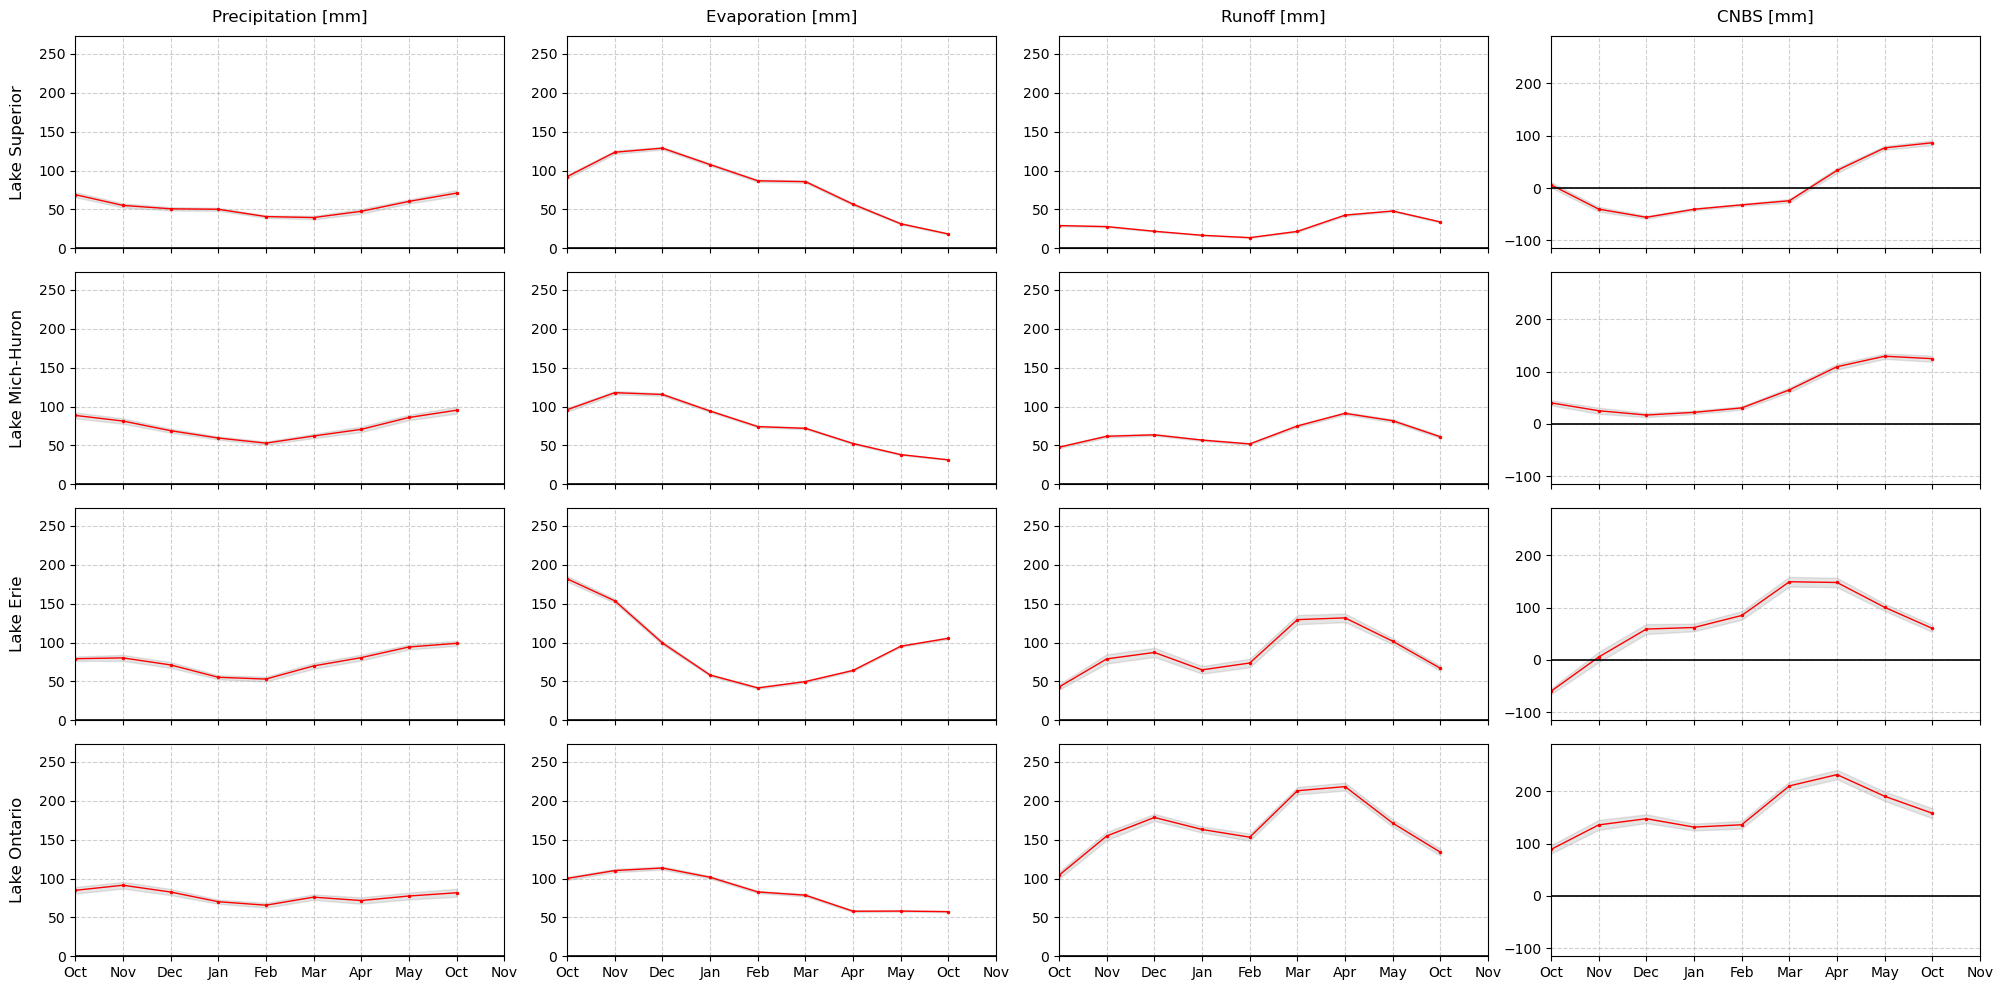

In [151]:
x_values = np.arange(len(su_precip_df['Mean']))
print(x_values)  # x-axis values
print(months['forecast_month'][7])
data_dict = {
    'Superior P': (su_precip_df['Mean'], su_precip_df['Lower CI'], su_precip_df['Upper CI']),
    'Superior E': (su_evap_df['Mean'], su_evap_df['Lower CI'], su_evap_df['Upper CI']),
    'Superior R': (su_runoff_df['Mean'], su_runoff_df['Lower CI'], su_runoff_df['Upper CI']),
    'Superior CNBS': (su_cnbs_df['Mean'], su_cnbs_df['Lower CI'], su_cnbs_df['Upper CI']),
    'Mich-Huron P': (mh_precip_df['Mean'], mh_precip_df['Lower CI'], mh_precip_df['Upper CI']),
    'Mich-Huron E': (mh_evap_df['Mean'], mh_evap_df['Lower CI'], mh_evap_df['Upper CI']),
    'Mich-Huron R': (mh_runoff_df['Mean'], mh_runoff_df['Lower CI'], mh_runoff_df['Upper CI']),
    'Mich-Huron CNBS': (mh_cnbs_df['Mean'], mh_cnbs_df['Lower CI'], mh_cnbs_df['Upper CI']),
    'Erie P': (er_precip_df['Mean'], er_precip_df['Lower CI'], er_precip_df['Upper CI']),
    'Erie E': (er_evap_df['Mean'], er_evap_df['Lower CI'], er_evap_df['Upper CI']),
    'Erie R': (er_runoff_df['Mean'], er_runoff_df['Lower CI'], er_runoff_df['Upper CI']),
    'Erie CNBS': (er_cnbs_df['Mean'], er_cnbs_df['Lower CI'], er_cnbs_df['Upper CI']),
    'Ontario P': (on_precip_df['Mean'], on_precip_df['Lower CI'], on_precip_df['Upper CI']),
    'Ontario E': (on_evap_df['Mean'], on_evap_df['Lower CI'], on_evap_df['Upper CI']),
    'Ontario R': (on_runoff_df['Mean'], on_runoff_df['Lower CI'], on_runoff_df['Upper CI']),
    'Ontario CNBS': (on_cnbs_df['Mean'], on_cnbs_df['Lower CI'], on_cnbs_df['Upper CI'])
}

plot_cnbs_forecast(x_values, data_dict)